# Actor Crtic for Continous Action Environment

In this notebook, we will implement Actor Critic algorithm for Mountain car continous Environment.

## Mountain Car

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reward Function

As mentioned above, s negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

However, you can change this reward function and write a custom one if you like and think it will make the agent learn better.

## Actor Critic Methods

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.




### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

Due to the usage of this advantage function, this algorithm is also **Advantage Actor Critic (A2C)**.
<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


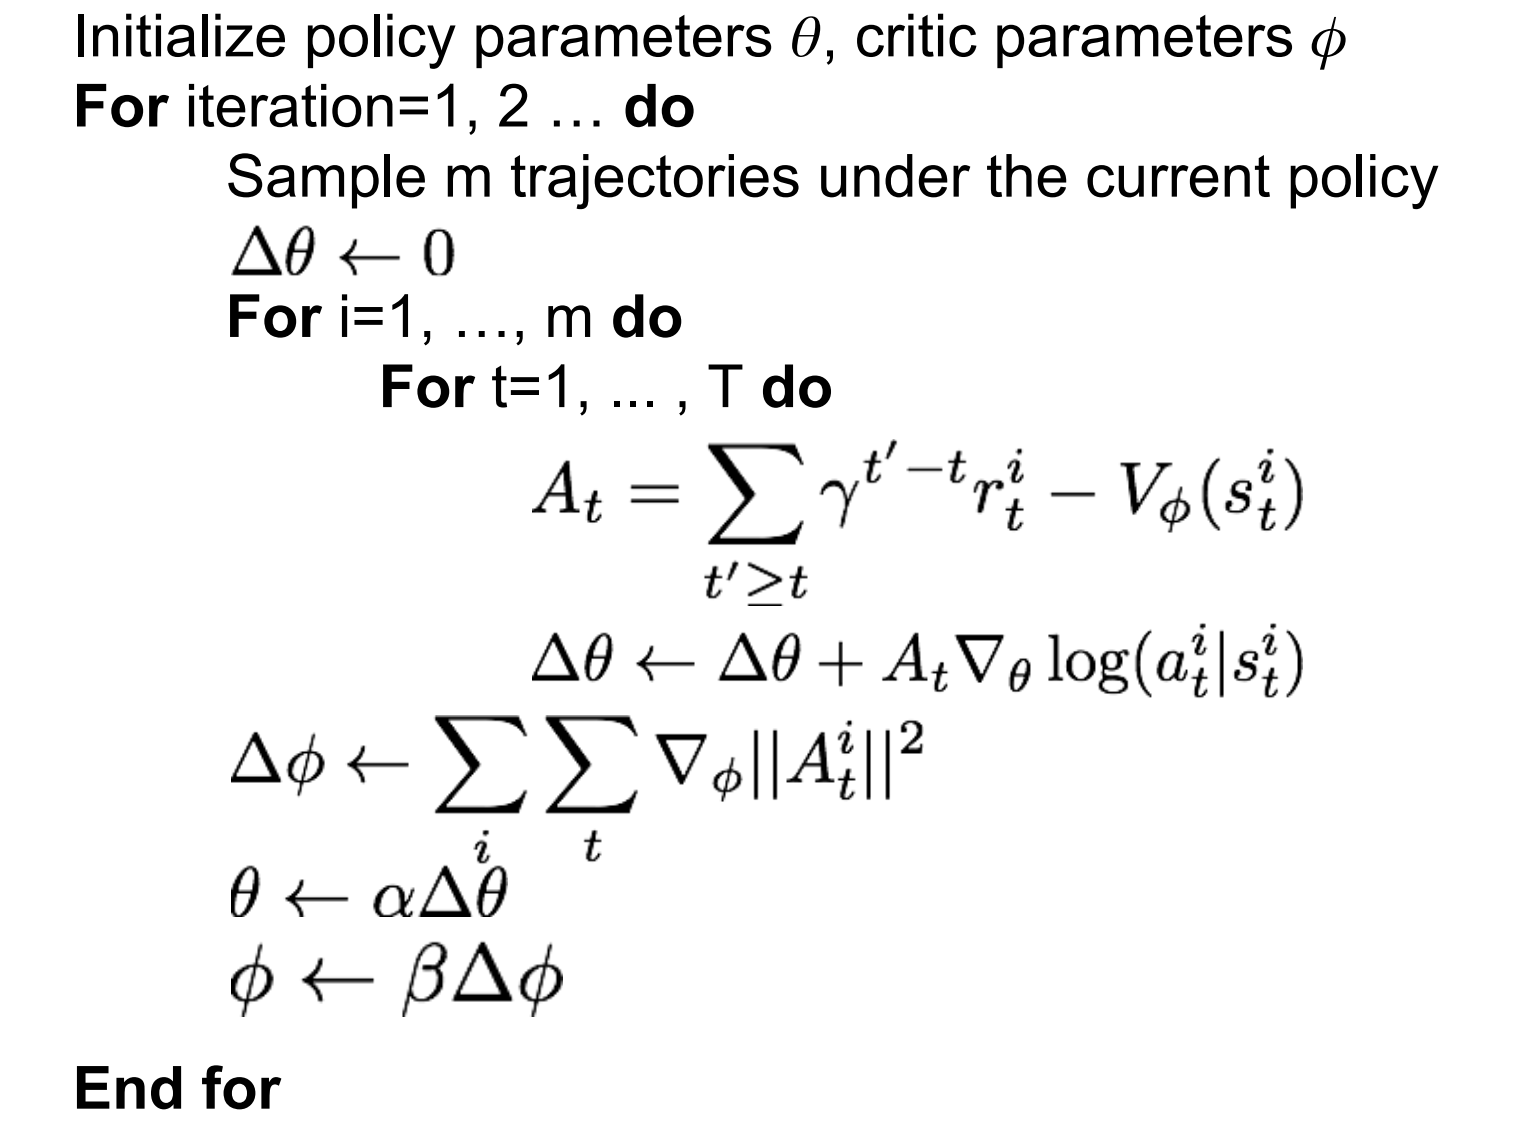

[Image Source](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf)

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal
from torch.distributions import Categorical

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Network

In [5]:
class ActorCritic(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.affine1 = nn.Linear(n_observations, 128)
        self.affine2 = nn.Linear(128, 128)
        self.affine3 = nn.Linear(128, 256)
        self.affine4 = nn.Linear(256, 256)

        # actor's layer
        self.action_head = nn.Linear(256, n_actions + 1)

        # critic's layer
        self.value_head = nn.Linear(256, 1)

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x2 = F.relu(self.affine2(x))
        x3 = F.relu(self.affine3(x2))
        x4 = F.relu(self.affine4(x3))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.tanh(self.action_head(x4))

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x4)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_value = self.forward(state)
        # create a categorical distribution over the list of probabilities of actions
        m = Normal(probs[0][0], abs(probs[0][1]))
        # and sample an action using the distribution
        action = m.sample()

        return action.item(), m.log_prob(action), state_value.squeeze(0)

### Hyperparameters

In [6]:
# Here, we will specify the hyperparameters
total_episodes = 2000    # Total training episodes
max_steps = 1000             # Max steps per episode
learning_rate = 1e-2         # Learning rate|
gamma = 0.999              # Discounting rate
update_steps = 3

In [7]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
print('state size:', n_observations)
print('action size:', n_actions)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


In [8]:
# Intialize policy network - model
actor_critic = ActorCritic(n_observations, n_actions).to(device)

# set up the optimizer
optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

### Training

In [9]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = actor_critic.act(state)
    action = [action] # convert to numpy array
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if done:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] # list to save actor (policy) loss
  value_losses = [] # list to save critic (value) loss

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    advantage = R - value.item()

    # calculate actor (policy) loss
    policy_losses.append(-log_prob * advantage)

    # calculate critic (value) loss using L1 smooth loss
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  # sum up all the values of policy_losses and value_losses
  loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

  # Back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  print(f"Episode {episode}: Reward = {scores[-1]}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Reward = -0.3313959535792698
Episode 2: Reward = -65.10803501985274
Episode 3: Reward = -144.9158765264348
Episode 4: Reward = -200.7270014350824
Episode 5: Reward = -203.49777873966974
Episode 6: Reward = -200.69945371185185
Episode 7: Reward = -187.58066086290097
Episode 8: Reward = -157.60057736513167
Episode 9: Reward = -118.72781678731924
Episode 10: Reward = -86.22271935200062
Episode 11: Reward = -53.571725712452405
Episode 12: Reward = -35.638766274915625
Episode 13: Reward = -16.079661241012637
Episode 14: Reward = -24.051860116897828
Episode 15: Reward = -38.82996235095124
Episode 16: Reward = -72.42239266796263
Episode 17: Reward = -108.42213184104479
Episode 18: Reward = -124.20217112428668
Episode 19: Reward = -111.72502392621914
Episode 20: Reward = -112.74412070572826
Episode 21: Reward = -127.538975274978
Episode 22: Reward = -144.33325791814437
Episode 23: Reward = -157.14166920028748
Episode 24: Reward = -162.74656512965672
Episode 25: Reward = -149.7600680

Text(0, 0.5, 'Reward')

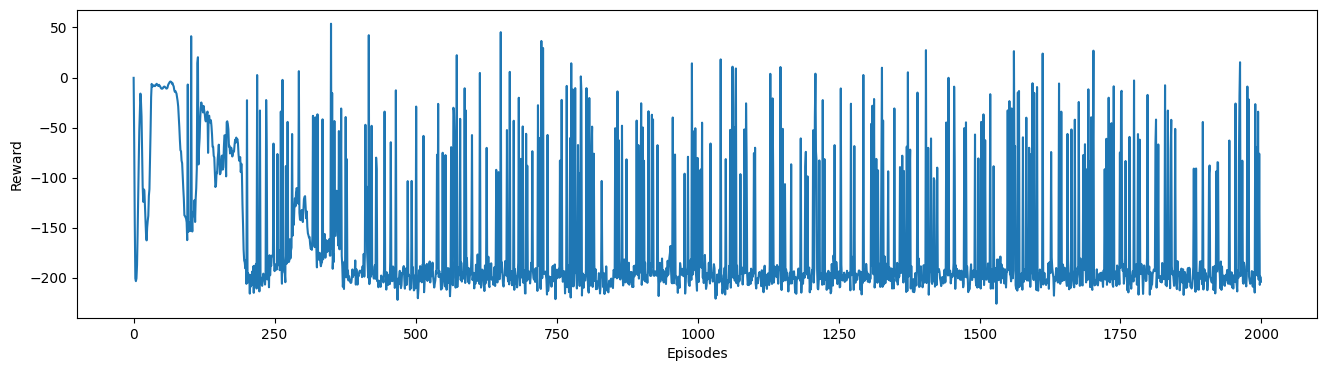

In [10]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [11]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [12]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        actor_critic = ActorCritic(n_observations, n_actions).to(device)
        action, _, _ = actor_critic.act(state)
        next_state, reward, done, info = env.step([action])
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [13]:
show_video_of_model("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializati

In [14]:
show_video("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
